# **Sampling from the Solution Space of Genome-Scale Metabolic Models**

By [Haris Zafeiropoulos](https://hariszaf.github.io/) and [Daniel Rios Garza](https://danielriosgarza.github.io/) -- July, 2024

This notebook accompanies our chapter on the *“Flux Balance Analysis”* book, to be published in the protocol series Methods in Molecular Biology, by Springer Nature.

## **Setting working space**

You can either launch a Codespace based on this repository or run the project locally on your machine.

* **codespace**: Quick and easy to get started. Ideal for initial exploration, but may limit your ability to run custom experiments later on.

* **local**: Requires some setup and may involve troubleshooting environment issues, but gives you full control. Recommended if you plan to use your own data or customize the workflow later.



Here is how to go for each of those two cases.

### **Build a codespace**

To fire a codespace, you will need a GitHub account and then from our [GitHub repo](https://github.com/hariszaf/metabolic_toy_model/tree/sampling), use the `sampling` branch to create your codespace.

* First, click on the arrow on the `Code` button
* then, click on `Codespaces`
* and on the three dots `...`, to create a `New with options...`

![](files/figs/codespace-fire.png)

After you make sure you have the configuration as in the following picture, you may fire your codespace by clicking on the `Create codespace` button:

![](./files/figs/codespace-conf.png)

> **Advanced Tip**
>
> The [`devcontainer.json`](.devcontainer/devcontainer.json) describes the configuration of the codespace to be built. 
> 
> If you pay close attention, you will realise what you would need to make sure for your local build (see next paragraph).

### **Creating a Conda environment**

Here, we assume you have Miniconda or Anaconda installed in your machine. 

If you don't, you can follow [this tutorial](https://eduand-alvarez.medium.com/setting-up-anaconda-on-your-windows-pc-6e39800c1afb).

Also, the following instructions (regarding the environment) are for a Linux environment, but you can adapt them to your OS.
The `dingo` Python package is not available yet for arm64 architecture, so you will need to use an x86_64 machine.


1. Create a Conda environment using Python 3.10 and a name of your choice; in this example, we'll call our environment `sampling`:

```conda create -n sampling -y python=3.10```

2) Activate your environment


```conda activate sampling```

3. We will be using `dingo` for flux sampling on the solution space of a metabolic model. `dingo` requires `PySPQR`; a module that wraps the [SuiteSparseQR](https://people.engr.tamu.edu/davis/suitesparse.html) decomposition function, but comes with a bunch of hard dependencies, based on your operating system. See [here](https://github.com/yig/PySPQR?tab=readme-ov-file#installation) for more. In the following, we assume you are working on Linux and that you have `sudo` rights:

```
sudo apt-get update -y
sudo apt-get install -y libsuitesparse-dev
```

4. You can now install the Python libraries required:

```pip install -r requirements.txt```

You may need the `--user` flag for this step:

```pip install -r requirements.txt --user```

5. You are now ready to go for it! 

In case you are working on VS Code or any other IDLE, make sure to set the kernel of the notebook to the `conda` environment you just built.

For example, if using VS Code, when you will try to run the first chunk of code, you will get a message like this:

![](./files/figs/select_kernel.png)

Then, you can click `Select Another Kernel... > Python Environments...` and you should look for the name of the environment you gave earlier, in our case `sampling`.

However, it's quite possible that IDLE will recognize the new environment after you close and relaunch it. 

In case you wish to use the `PolyRound` library for rounding metabolic models, then you will need to clone the repository and install it as follows:

```bash
git clone https://gitlab.com/csb.ethz/PolyRound.git
cd PolyRound
pip install -e .
cd ..
```

The `PolyRound` argues that their library works better when using Gurobi.

## **Intro**

### **Bio**

We assume the reader/user is already familiar with the basic concepts of metabolic modeling and the basics of the `cobrapy` library. 

If this is not the case, you may **first** go through our according material on [this branch](), we were able to come up with for the 
needs of the [METABOLIC MODELS APPLIED TO MICROBIOMES](https://metabolicmodelingantony2025.onrender.com/) workshop.



As throughout this repository, we use metabolic models from three human gut-associated strains that are known for:

* occupying key ecological niches in the gut, and

* engaging in metabolic interactions with one another, as illustrated in the diagram below:



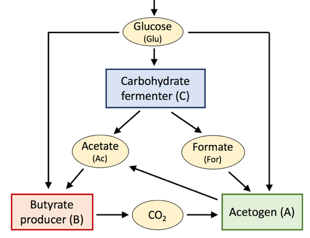

These ecological niches are based on the metabolism of the following three species:

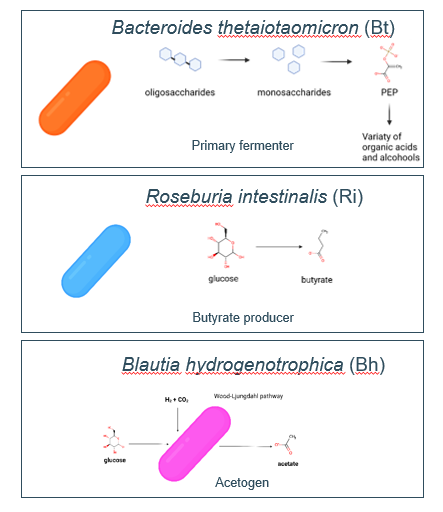

We will run our single-species sampling scenarios using an AGORA model for Bt and only in the community case we will use all three of them. 

### **Technical**

In case your Jupyter notebook does not line with the `sampling` environment, you may give it a shot after running:

In [1]:
import os
import sys

In [ ]:
env_site_packages = os.path.join(os.getenv('CONDA_PREFIX'), 'lib/python3.10/site-packages')  # Adjust for your Python version
if env_site_packages not in sys.path:
    sys.path.append(env_site_packages)

By now, you should be able to load the libraries required for this notebook:

In [2]:
# General
import time
import pickle
import numpy as np
import pandas as pd
from typing import List
from pathlib import Path


# Sampling
import cobra
from cobra import Model
from cobra.sampling import ACHRSampler, OptGPSampler

import dingo
# import dingo_walk as dingo

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

# Local scripts
from scripts import mambo
from scripts.utils import apply_environment, dump_samples, load_samples
from scripts.stats import pca_samples, significantly_altered_reactions, plot_hists

# Stats
import arviz as az
from numpy.typing import NDArray

from sklearn.preprocessing import StandardScaler

Now you are good to keep track of the models to be used. 

In [3]:
root_dir = Path().resolve()

agora_models_path = root_dir / "files" / "models" / "AGORA"

bt_agora_filename = "Bacteroides_thetaiotaomicron_VPI_5482.xml"
bh_agora_filename = "Blautia_hydrogenotrophica_DSM_10507.xml"
ri_agora_filename = "Roseburia_intestinalis_L1_82.xml"

And decide on what **solver** you will be using. 

To solve the optimization problems in our model, a solver is required; special software that can solve a wide range of problem types, such as linear programming, mixed-integer linear programming, quadratic programming, mixed-integer quadratic programming etc.

These problems are rather common in metabolic modelling and most of the analyses performed in the field, are based on solving such optimization problems.

Let's see an example when loading a model with `cobra`:

In [4]:
bh_model = cobra.io.read_sbml_model(agora_models_path / bh_agora_filename)
bh_model.solver

In case Gurobi for example was available, `cobra` would prefer it and you would seed something like: 
```
>>> bt_model.solver
<optlang.gurobi_interface.Model object at 0x7da11588e9c0>
```

To check what solvers are available on your **environment**, you may run:

In [5]:
import optlang
print(optlang.available_solvers)

{'GUROBI': True, 'GLPK': True, 'MOSEK': False, 'CPLEX': False, 'COINOR_CBC': True, 'SCIPY': True, 'OSQP': True, 'HIGHS': True}


> You can think of Optlang as the SQLAlchemy of optimization
>
> SQLAlchemy isn't a database, but lets you talk to different databases using a unified interface.
>
> Optlang isn't a solver, but lets you talk to different solvers in a unified way.


Latest versions of `cobra` use [`optlang`](https://optlang.readthedocs.io/en/latest/) to describe their linear programs, which works as an interface to a series of solvers that may be available on your computing environment, e.g. GLPK, Gurobi etc. 

[Gurobi](https://www.gurobi.com) requires a paid license, but can also [be obtained](https://www.gurobi.com/downloads/) for free under an [academic license](https://www.gurobi.com/downloads/end-user-license-agreement-academic/). [CPLEX](https://www.ibm.com/products/ilog-cplex-optimization-studio) too. 

On the other hand,[`glpk`](https://www.gnu.org/software/glpk/), [HIGHS](https://ergo-code.github.io/HiGHS/dev/) and others are open source and free. 

`dingo` uses HIGHS as its default solver; `highspy` should already been installed on your environment. 
You can always use the `glpk` instead, but would take considerably longer in Genome Scale models.

Thanks to HIGHS, `dingo` besides `glpk` supports: 

- `highs` 
- `gurobi`
- `copt`
- `mosek`

In [5]:
# Directory to save sample datasets
samples_path = root_dir / "results" / "samples"
os.makedirs(samples_path, exist_ok=True)

## **Sampling scenarios**


While FBA finds a single maximum for the objective function, one might be interested in the space of viable metabolisms. This space reveals the range of conditions where the cell could live without the assumption of maximizing an objective function.

The space of viable metabolisms is explored by taking uniform samples from the flux distribution. Besides revealing the cell's metabolic potential, these samples also reveal the conformations of higher likelihood and the burden of regulation needed for the cell to achieve its "maximum growth". 

In the following we provide examples of how to perform and apply flux sampling to address a range of questions. 

In most parts of the notebook, we will be using an AGORA GEM of *Blautia hydrogenotrophica* (Bh).

In [6]:
bh_xml   = (agora_models_path / bh_agora_filename).as_posix()
bh_model = cobra.io.read_sbml_model(bh_xml)

In [7]:
bh_reactions = [rxn.id for rxn in bh_model.reactions]

In [8]:
bh_dmodel = dingo.MetabolicNetwork.from_sbml(bh_xml)

### **Random walks, solvers and diagnostics**

We will sample using Bh model, using the two algorithms provided in `cobra` (OptGP and ACHR), and two of those supported by `dingo` (MMCS and Billiard walk), using their default solvers (GLPK and HIGHS correspondingly). 

The sample datasets will be saved as pickle files under `results/samples/`.

In [87]:
solvers     = ["default", "gurobi"]  # default: GLPK
cobra_walks = ["OptGP", "achr"]
dingo_walks = ["MMCS", "billiard_walk"]

bh_xml = (agora_models_path / bh_agora_filename).as_posix()

# Dictionary with time required for each sampling experiment
times = {}
for solver in solvers:

    for walk in cobra_walks:

        if solver != "default":
            model.solver = "gurobi"
            lsolver = solver
        else:
            lsolver = "glpk"

        print(f"Walk: {walk}, Solver: {lsolver}")

        # Load as cobra model
        model = cobra.io.read_sbml_model(agora_models_path / bh_agora_filename)

        t1 = time.time()
        if walk == "OptGP":
            
            exp     = OptGPSampler(model, thinning=100, processes=4)
            samples = exp.sample(10000)

        elif walk == "achr":
            
            exp = ACHRSampler(model, thinning=100)
            samples = exp.sample(n=10000)

        t2   = time.time()
        case = "_".join([lsolver, walk, "unb"])

        times[case] = f"{t2 - t1:.2f}"
        dump_samples(samples, samples_path/ ".".join([case, "pkl"]) )


    for walk in dingo_walks:

        if solver != "default":
            model.solver = "gurobi"
            lsolver      = solver
        else:
            lsolver = "highs"

        print(f"Walk: {walk}, Solver: {lsolver}")

        # Load as dingo model
        model  = dingo.MetabolicNetwork.from_sbml(bh_xml)

        # Replace the objective function with an empty zero-array
        model.objective_function = np.zeros(model.num_of_reactions())
        
        sampler = dingo.PolytopeSampler(model)
        sampler.set_solver("gurobi")

        if walk == "MMCS":

            samples = sampler.generate_steady_states(ess=3000, psrf=True)

        elif walk == "billiard_walk":

            samples = sampler.generate_steady_states_no_multiphase(
                method   = "billiard_walk",
                n        = 10000,
                burn_in  = 10,
                thinning = 100
            )

        t2   = time.time()
        case = "_".join([lsolver, walk, "unb"])

        times[case] = f"{t2 - t1:.2f}"
        dump_samples(samples, samples_path/ ".".join([case, "pkl"]) )



Walk: OptGP, Solver: glpk
Walk: achr, Solver: glpk
Walk: MMCS, Solver: highs
phase 1: number of correlated samples = 3600, effective sample size = 23, ratio of the maximum singilar value over the minimum singular value = 31343.7
phase 2: number of correlated samples = 3600, effective sample size = 1227, ratio of the maximum singilar value over the minimum singular value = 24.1203
phase 3: number of correlated samples = 3600, effective sample size = 1533, ratio of the maximum singilar value over the minimum singular value = 3.37813



 [1]maximum marginal PSRF: 1.35628
[2]maximum marginal PSRF: 1.00114
[2]total ess: 3187


phase 4: number of correlated samples = 1200, effective sample size = 427Walk: billiard_walk, Solver: highs
Walk: OptGP, Solver: gurobi
Walk: achr, Solver: gurobi
Walk: MMCS, Solver: gurobi
phase 1: number of correlated samples = 3600, effective sample size = 26, ratio of the maximum singilar value over the minimum singular value = 28788.1
phase 2: number of correlated samples = 3600, effective sample size = 1098, ratio of the maximum singilar value over the minimum singular value = 25.1831
phase 3: number of correlated samples = 3600, effective sample size = 1613, ratio of the maximum singilar value over the minimum singular value = 3.39359



 [1]maximum marginal PSRF: 1.36478
[2]maximum marginal PSRF: 1.0017
[2]total ess: 3112


phase 4: number of correlated samples = 1200, effective sample size = 401Walk: billiard_walk, Solver: gurobi


Load a sample dataset and get its ESS.

In [88]:
df = load_samples(samples_path / "gurobi_OptGP_unb.pkl")
if isinstance(df, np.ndarray):
    df = pd.DataFrame(
        df, 
        index=[rxn.id for rxn in bh_model.reactions]
    ).T

In [89]:
# Keep values of the dataframe
data = df.values

# If you are aware of the number of chains produced during sampling, replace None with the number of chains and edit the shape accordingly.
# For example, if you had 10000 samples coming from 4 chains, you should reshape like this: [4, 2500, :]
data = data[None, :, :]
dataset = az.convert_to_dataset({"samples": data})

# Estimate ess
ess = az.ess(dataset)  # by default, method is `bulk`, see: https://python.arviz.org/en/stable/api/generated/arviz.ess.html

In [96]:
print(
    f"ESS mean: {ess.mean()}\n---\n"
    f"ESS minimun: {ess.min()}"
)

ESS mean: <xarray.Dataset>
Dimensions:  ()
Data variables:
    samples  float64 4.222e+03
---
ESS minimun: <xarray.Dataset>
Dimensions:  ()
Data variables:
    samples  float64 1.944


In [97]:
ess_values        = ess['samples'].values 
low_ess_idx       = (ess_values < 1000).nonzero()[0]
low_ess_reactions = df.columns[low_ess_idx]

count_ex      = 0
count_blocked = 0
count_fixed   = 0
for rxn_id in low_ess_reactions.values:
    if rxn_id.startswith("EX_"):
        count_ex +=1
    else:
        if abs(df[rxn_id].mean() ) < 0.001:
            count_blocked += 1
        elif abs(df[rxn_id].max() - df[rxn_id].min()) < 0.1:
            count_fixed += 1


print(f"Number of exchange reactions on the model: {len(model.exchanges)}")
print(f"Number of total reactions with low ESS: {len(low_ess_reactions.values)}")
print(f"Number of exchange reactions among those with low ESS: {count_ex}")

Number of exchange reactions on the model: 111
Number of total reactions with low ESS: 621
Number of exchange reactions among those with low ESS: 96


Now you can load your samples:

In [9]:
optgp_samples = load_samples(samples_path / "gurobi_OptGP_unb.pkl")
achr_samples  = load_samples(samples_path / "gurobi_achr_unb.pkl")
mmcs_samples  = load_samples(samples_path / "gurobi_MMCS_unb.pkl")
bw_samples    = load_samples(samples_path / "gurobi_billiard_walk_unb.pkl")


And we can plot any marginal distribution we are interested in. 

Below we plot the biomass distribution from all the 4 different walks applied, when using Gurobi as our solver.

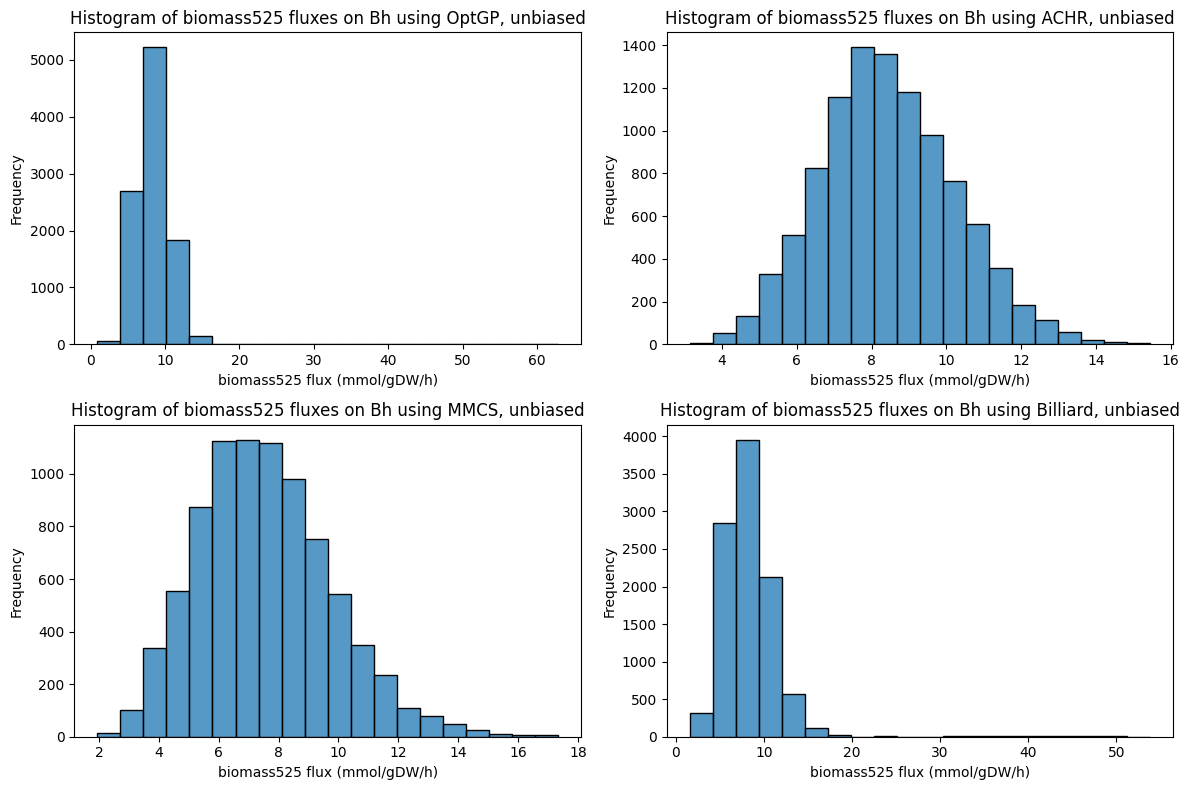

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

plot_hists(
    optgp_samples, "biomass525", type = "cobra", 
    description = "on Bh using OptGP, unbiased", ax=axes[0, 0]
)
plot_hists(
    achr_samples, "biomass525", type = "cobra", 
    description = "on Bh using ACHR, unbiased", ax=axes[0, 1]
)
plot_hists(
    mmcs_samples, "biomass525", type = "dingo", 
    dingo_model = bh_dmodel, description = "on Bh using MMCS, unbiased", ax=axes[1,0]
)
plot_hists(
    bw_samples, "biomass525", 
    type = "dingo", dingo_model = bh_dmodel, description = "on Bh using Billiard, unbiased", ax=axes[1,1]
)

plt.tight_layout()
plt.savefig("results/samples/optg_achr_mmcs_bW_bh_unbiased2.eps", format="eps", dpi=600)
plt.savefig("results/samples/optg_achr_mmcs_bW_bh_unbiased2.png", format="png", dpi=300)
plt.show()

### **Rounding**


PolyRound is an exceptional Python library specialized in rounding polytopes. 

In [ ]:
from PolyRound.api import PolyRoundApi
from PolyRound.settings import PolyRoundSettings
from PolyRound.static_classes.lp_utils import ChebyshevFinder

# Fix settings
settings         = PolyRoundSettings()
settings.verbose = True
settings.backend = "gurobi"

# Export initial and perform rounding tasks
polytope             = PolyRoundApi.sbml_to_polytope(agora_models_path / bh_agora_filename)
polyrounded_polytope = PolyRoundApi.simplify_transform_and_round(polytope)

Sample using the *polyround-*ed polytope and the MMCS `dingo` algorithm.

In [ ]:
mmcs_polyrouned_samples = dingo.PolytopeSampler.sample_from_polytope(
    np.asarray(polyrounded_polytope.A),
    np.asarray(polyrounded_polytope.b),
    ess  = 1000,
    psrf = True
)

In [ ]:
print(
    f"Dimensions of the samples retrieved from the polyrounde-ed polytope: {mmcs_polyrouned_samples.shape}\n"
    f"Number of reactions in the Bh model: {len(bh_model.reactions)}"
)


Apply back transformation to map samples to their original space. 

In [ ]:
mmcs_poly_samples = polyrounded_polytope.back_transform(mmcs_polyrouned_samples)

In [ ]:
mmcs_poly_samples.shape

In [ ]:
dump_samples(mmcs_poly_samples, "results/samples/bh_mmcs_poly.pkl")

You can sample on the *polyround*-ed polytope, using any kind of sampling algorithm, but you always need to remember to back transform the samples to the original space.

In [ ]:
# Sample on polyrounde-ed polytope using Billiard walk 
bw_polyrounded_samples = dingo.PolytopeSampler.sample_from_polytope_no_multiphase(
    np.asarray(polyrounded_polytope.A),
    np.asarray(polyrounded_polytope.b),
    method   = "billiard_walk",
    n        = 10000,
    thinning = 100
)

# Back tansformation
bw_poly_samples = polyrounded_polytope.back_transform(bw_polyrounded_samples)

### **Unbiased sampling: the medium effect**

To 'control' the composition, set the lower bound. But take into account that these are constrained-based models. To 'force' the models to consume a defined amount, set the lower and upper bound to this amount (this often leads to unfeasible models)

In [16]:
print(
    f"Number of metabolites in the medium of the Bh model: {len(bh_model.medium)}\n"
    f"Number of total exchange reactions available in the model: {len(bh_model.exchanges)}"
)



Number of metabolites in the medium of the Bh model: 111
Number of total exchange reactions available in the model: 111


Let us check how many different input-output cases we have in the unbiased sampling with MMCS and Gurobi.

In [25]:
unb_samples = load_samples(samples_path / "gurobi_MMCS_unb.pkl")
unb_samples = pd.DataFrame(unb_samples, index = bh_reactions).T

In [117]:
unique_io = count_ios(unb_samples, bh_model)

In [119]:
unique_io.shape

(110, 2443)

There are 2443 combinations of active exchange reactions in the complete medium of the model. 

Let us check what happens when we remove just the oxygen from that, so the medium looks a bit more like what's happening in the human gut where Bh lives.

In [ ]:
# Build a new cobra instance 
bh_model = cobra.io.read_sbml_model(agora_models_path / bh_agora_filename)

# Replace the initial medium with one that oxygen is not available
init_medium = bh_model.medium
anoxic_medium = init_medium.copy()
anoxic_medium["EX_o2(e)"] = 0 
bh_model.medium = anoxic_medium

# Sample in an unbiased way with dingo 
bh_dmodel = dingo.MetabolicNetwork.from_cobra_model(bh_model)

# Remember you need to shut down the objective function when using dingo
bh_dmodel.objective_function = np.zeros(len(bh_reactions))

In [ ]:
# Now you are ready to sample in an unbiased way in the anoxic case
sampler          = dingo.PolytopeSampler(bh_dmodel)
unb_anox_samples = sampler.generate_steady_states(ess=1000, psrf=True)

phase 1: number of correlated samples = 3600, effective sample size = 24, ratio of the maximum singilar value over the minimum singular value = 23677
phase 2: number of correlated samples = 3100, effective sample size = 1004


 [1]maximum marginal PSRF: 2.30232
[2]maximum marginal PSRF: 1.00523
[2]total ess: 1004


In [75]:
dump_samples(unb_anox_samples, samples_path / "bh_unb_anoxic.pkl")

In [113]:
a = count_ios(unb_anox_samples, bh_model)

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

In [92]:
a.shape

(110, 1160)

In [ ]:
bh_model.reactions.EX_biomass(e)

In [114]:
g = count_ios(unb_anox_samples, bh_model, "biomass525")

7.309092165412951
6.725111006709578
4.491687673637307
4.7026168902334
7.56902250237159
8.911389420952371
3.317742268925695
5.05812180963967
5.4235211838300135
5.317675137489297
5.867681031993515
9.054375445992848
7.664487802161677
6.779709232282871
5.904435747475525
7.8010566939624155
11.434755639998627
9.596261340237469
6.048458689403905
7.241449678862545
10.276497187961956
12.562821931877648
3.6540060967763788
5.0510823864946905
4.281079480785548
6.615606333715447
4.473028811498175
5.173250778740327
4.91385691151698
4.472089045593842
4.677750768012383
3.556004006043683
5.798520767256605
5.087468562298687
4.855885182766504
10.386293305409056
11.138535102880384
8.928890857126309
8.134174154066255
8.158266795323243
3.8269259110578724
4.193513979882479
5.440218677645645
3.644450760570248
6.253573833920609
6.522521874219721
6.295926083604691
5.553534528601683
6.032736126510177
9.778854403722816
7.441055427696647
6.909122358908364
8.925798357064629
7.888363749739347
7.183730597247846
6.594

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

8.248260926857007
7.919414570763575
4.561878239014091
3.783787573113495
4.879344222620918
7.07715310204021
7.191587504545715
4.083136471261303
5.953704518816688
8.135428478436856
9.818386183417376
7.570200048468432
8.360071559005913
6.185177950919113
5.772823637327016
4.977610153948106
5.003126083273714
5.071821951332915
4.4104633459544775
8.13242681908792
8.586108592745584
4.528359627614954
4.57573498230065
6.0773455266865275
6.430495569211359
5.6149088320342475
6.668468566787849
8.306258138048005
8.708729916304
10.052256371487758
5.3412583778667795
6.179214997058024
3.8523586132526044
8.670340824222812
6.609167125863872
3.987396926603369
4.6512269131374975
8.017519742578594
7.2123322187725085
7.320491754210928
6.871284622380743
9.171275683764668
11.886999028226167
8.517677811801976
7.637882520295684
5.975566606993302
6.713575318833628
6.082021135491235
7.48003961541372
5.736071157476478
3.602546814888787
5.688638394333544
5.819141669234244
4.820694255715299
5.076626121842669
5.601967

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

10.980412081266357
6.875132821204536
7.146464327398274
5.249960710754339
5.820989860810938
7.547000859732235
4.321678307856704
4.4356497528988035
7.749251993416198
7.6907162116050465
5.11111432694421
4.2620901924932415
10.515822224271277
10.208917178865422
6.381208091836499
7.291607494693552
6.3883930323846645
4.673971750533973
5.359143339058326
9.593431181462318
9.488195440335167
7.929387520301324
8.852805709680577
10.297318877502766
3.7136580775168695
6.353696474500425
5.319705626013554
6.811701113441323
10.522449620521531
11.066940241938267
7.7986337808452175
6.15623948267499
7.629244138183601
7.570934113182737
8.404856476419175
10.346552663755045
4.571662130424391
4.567115928992097
4.17333864810526
7.0421592694883675
6.404093406173416
5.81957311016581
7.668713777604084
7.981185600522859
6.0587870518592775
6.883048888825393
7.373727108252783
5.459354216930521
8.596496575051532
7.8790183398644835
4.486261677000892
4.160110261619334
7.949258198652314
6.394044728482907
5.72555817453804

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

5.7630557400017315
8.388800271942275
5.765481074602076
7.240253695372068
5.04427027878573
5.833456191923466
7.112381511180205
9.241197463792142
2.851434090554268
4.427355444300874
5.4474804944078965
7.553112718018799
6.7256573466022
6.977891149487628
5.888654373347339
5.989753213332601
4.746028226133462
3.515719350539228
7.853501235135222
7.119632112355055
7.359223424781212
4.757155710015114
9.121957944967683
3.9634158674433575
3.294696495612885
4.812499033594251
5.912095983751743
7.92123817541373
7.708355350133026
4.515126332145345
5.975326886380686
7.870633530244881
4.661661598182972
6.133686506899039
7.334938923545924
10.016340254676475
8.207771403656764
10.9688473569246
12.158296412275995
9.888939937309159
12.045581959804936
8.508211629907438
8.121388712453408
5.563312922842182
11.462044924489755
8.46471076575917
5.771782183981395
4.290625548482107
6.460752448797355
5.486267310592852
6.0144612715548815
3.8005484579268245
5.81077833980228
9.041547597202188
5.988230098748362
5.066899

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

5.433778974551298
6.238495215293476
7.387628676892685
9.247409412601543
7.61054446025318
7.59001878882006
9.78499236962419
9.388845543410765
10.13268064770011
9.52815568789578
7.951426613156107
6.62154925165226
6.724812815461881
4.3550082141458715
6.922434398687785
6.720704318798967
5.634411000265854
5.667324872020228
5.543199455669378
6.217052789354713
10.454173383167536
4.25048570574177
4.812877992570418
4.4533657509707325
5.2565970023731285
7.024368031085464
5.266800171285126
6.599421918914788
5.970128027804021
10.41115179436466
5.429142604349049
7.152165777102103
5.237705259482218
9.183564612518351
8.58804811758033
6.980974814174783
7.93715248395704
5.536352281639188
6.2656793138942355
5.426397625173088
9.704111062352005
8.584263096662912
6.131605858506911
5.049075298496372
9.758057707919086
11.415394139962386
9.293673685626091
10.000493617694115
6.794493994293498
9.935737272456658
7.87936686134562
7.738227979253758
8.066389713503396
3.1715031460693446
7.7280518024603255
7.03848269

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

5.842518988110744
8.995018259560284
6.215093517052574
4.760239585865248
8.277938573247384
9.421504432210064
6.841525563295912
5.003836478199723
5.277049583992762
7.570099731934426
7.8858946247444095
3.830303335416933
5.527223042784436
6.707342214220178
10.619446774068647
8.6101625222833
9.052433568174298
7.5587750563178
7.584442324247981
9.320773664623681
5.103802169324224
4.39251809400779
5.594839592165287
4.99114077599572
8.584869089109793
8.415423185048935
9.350875830501296
8.543260553099111
5.206561699426509
4.072229518420361
5.763058050612704
6.954512970545307
7.969681324190882
8.131119279233628
5.332591226358507
6.4060893654008755
12.158933207523793
12.637526071130893
9.810448259477392
10.123981745403885
7.848718241285279
8.250836749406012
5.143037979434381
7.711625554067399
10.102063998895463
7.421809267613411
12.175296936355052
6.155496955514483
5.807642657049343
5.862970023624405
6.016283417075406
4.724552115259042
5.7231288117746635
3.961059928586513
4.487172466773287
5.66749

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

11.258570297236261
8.489011046265245
9.077815807039599
13.193387818323426
8.401612018776504
3.997366144726287
6.973320995392005
3.905776722839338
3.2409748241359186
7.328257039088949
5.3635801648357
4.046168989978922
8.317709970963792
6.405959189654227
5.307025100259695
5.199908795723214
6.306133149836421
5.784741767193424
7.648664650061005
5.903048084322864
8.066449505913052
6.294484952324889
5.18953062572412
5.799254442366904
5.0085579779437595
5.9837297935379015
8.056780483091295
10.745749485385868
11.123338624176395
3.6615591824170792
4.316550676918871
4.63708144648622
4.351926982579173
5.962228052067238
5.693681727041046
4.383509018996118
7.326619807013729
3.9545545427989715
3.491972010677462
3.1901821167742526
4.088329592201675
6.654705744294066
6.845871639628422
5.832323973381013
3.6198504565531295
5.5010203712085834
2.2046985171692612
4.977303025988472
7.611627900140436
5.062373634242294
8.345406173223253
11.676997365101757
12.010393160343309
3.8507709615048022
3.02532574404160

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

6.11245381185979
6.001392965446892
9.637636720999108
8.922461197178027
8.066855947195284
10.027256027381426
7.48636933008606
9.551547911176042
10.47098188508179
14.556644345402466
9.0669860893485
4.427220264622162
8.514836185399213
8.39349494566234
7.257753528942685
8.779556857817427
7.603762755222702
6.692772255867684
5.545295966871592
5.055133969435823
2.470554030917121
7.5369547262065435
7.035534174708585
8.286192987647278
7.145464139019813
8.885277370699614
9.941665869444972
4.863934913927803
4.041630697891255
5.073960853437509
6.806557681025894
5.173713077255492
5.46553414666177
6.595049409888774
8.225345061534977
5.65702976258512
6.422544998466218
7.176406424784091
6.621320451027794
6.850297821040888
6.420716390849781
11.452159221353902
7.701478480744587
6.297575454097886
6.198365184407977
5.552739683546868
5.259498814715481
5.851038584424599
6.621848318636693
6.6732058946920745
4.819091132734822
5.703012795198259
5.651794931743157
6.053925348189141
7.8610697612198175
8.054723486

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

9.418827713930906
8.234055437176512
7.486158291534202
9.108792333997512
5.35363544158102
5.614084779793475
6.076049285481109
6.6703201196225725
6.815228260253249
8.916431805807003
6.948986738849448
5.891182186706964
6.857516029699544
6.3738207070343655
8.259603174676679
9.86670223045624
9.5109970201257
10.09127367379043
7.110800844252925
7.946287369632218
7.661339042242716
3.525875602636862
2.29345053748728
5.015916464879538
6.711859457137237
6.6372710439490685
5.031279177786173
3.6245293748490384
4.644538199565978
5.895520908926632
9.08593718462575
9.238539688786817
6.788371510155399
8.044935389155533
6.713631610323892
6.31030931544663
5.5154524763366695
6.1683966022431305
5.098408651703514
5.498961403521878
4.368497480357018
6.665148598317182
12.26653590118529
10.449839811966486
12.374830307353564
9.926084873183342
8.442197904689747
10.044740345966982
7.208408391063183
4.962954146759429
6.394960709365474
11.29434019352602
6.790300021740229
6.162663300426962
7.298462901915333
5.732116

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

2.661519399017043
5.879816298217193
5.619392644482782
6.27088712672554
9.51698772354399
5.131821233586292
5.416261739742894
7.015874113642703
4.40672665064022
6.326738804516278
7.323816057469453
8.236207600569923
6.652053593040096
4.6101704741390135
6.31236747270031
5.505266020598133
8.398090128236532
7.69413501348343
8.641763651947597
10.436481791589165
10.27646215320954
6.662440988884154
2.5428703360357154
2.859592546391962
4.29151633393806
4.844077466789709
3.492860431614833
3.843736037592176
5.277969526429084
3.910490118516732
7.312783928775436
7.270299347275302
4.549206323230667
6.130683923263628
7.933583319188985
5.293154266842805
7.747093457202796
8.260933616166199
7.805347358998105
6.099946111792148
7.312162387642619
10.328324163249393
7.4888698554003446
3.3142295701323548
4.051291670582253
3.835021310931936
8.150773478194033
6.72930449946022
5.877498031949826
5.509632912384986
4.173570550100688
3.6186086542911484
6.761687739135419
4.892092566436969
5.2017888460894115
7.5325455

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

6.170554233687553
7.500357121239164
7.94632027774438
6.723939358896223
7.646734080141946
5.3403766099117655
6.065489964786267
6.0829934706930056
3.449463202804313
5.40178549241116
4.9935014677400575
6.474365170356761
5.629983531803264
5.15547059010472
8.257038386817136
11.06740206480543
7.577143087573567
6.196610001905916
3.990088626563526
8.311361149065702
7.917110935507791
7.391804990431579
5.549996739169951
5.926081945192063
5.37686088560165
6.730465671318396
4.924109766797651
4.188863202500231
5.443671756707803
4.652737658468811
11.796523041995528
10.3905528371354
6.897408704496789
6.140072066681016
6.771363229711114
6.816210682678017
6.495313315250898
4.593018308996562
4.26165986158554
3.8139249956640726
3.5299033211630237
3.2473196800789412
6.01289012240743
9.457477941562356
5.840003132145884
6.676882030085162
7.996722064152102
6.85952463997015
9.351853847770288
6.393973275957286
7.560402772252122
6.683771002491899
7.131372885772599
5.661762801899126
6.2949325890949375
5.60056566

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

8.353666274044613
10.812001688990884
8.811827863997443
4.690135951739344
4.397307397133183
5.368945530426262
5.5597623305103445
6.855813006465124
8.002691559723761
7.379698023088055
8.25871647573691
6.033721166668383
7.043095115970416
4.516674346749363
3.321238312536556
5.272380875687365
11.387509998473167
8.822583983172454
6.525845421214033
8.118323155953613
9.0471236500425
8.420417743854104
6.128997331730401
8.689932800440564
7.504103045107282
6.217745133908436
5.591232498853635
7.028541635023121
5.9324492170804275
6.944101799392346
6.0834284790789255
4.16095557904987
5.321618514499356
7.425288803564252
7.051127665732075
7.87467831213258
5.427534805142166
9.847985138334062
10.546001541352656
5.178486082701192
7.005802556122285
6.399346924711323
6.4959880086516275
3.636251665709621
3.0044446538418357
5.8063261100797
7.81340976227783
7.782224348435945
8.632972056506828
3.717798131912112
7.485043996291069
5.3429133072978345
7.039105892236639
8.26883553907367
7.645322353131721
7.37247871

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

6.716406192604077
7.689562341944316
5.7827737716879914
10.386964777696946
6.051394739358397
7.627756273088859
6.3899244161271955
6.775177276182857
8.436822033921617
6.483493584652
9.809013389263367
8.572819091001326
9.084127357333
9.282903530892384
7.512248450448322
8.806182582636053
7.835090921268344
8.05035544336471
8.027864430968092
7.587920388834742
5.790072046440781
4.090709525429885
6.386878514253932
5.462912328652297
13.403733354969793
6.706696553946401
6.715748605331754
3.3296754383600864
6.292053151107602
5.810120298968226
6.881182277961872
6.9176895705280605
6.7471465781882545
6.618484624359478
4.537226339596036
9.087855534082578
7.836685718330471
5.729111636284054
6.741595881250929
6.029318748535773
7.550791342457367
11.12422861801356
8.567756643041673
5.527324966414721
8.165613641514678
6.57772332281922
8.835629326555289
6.13067034083126
3.714527914908624
3.4622751951234143
5.017777442354164
7.8719991017586874
5.453947194255439
6.378451681691563
7.774691630406977
10.3822152

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

5.058567639213487
6.7429989942053465
6.4711830660378284
3.7870221172887755
4.099804188716197
3.9006403810571095
4.469524732319035
5.38002937350429
6.3836785126501105
5.754746920981438
8.24630489519004
8.823050762829954
8.423271237894976
6.018057154007174
4.787855901515119
5.729125505545507
5.124696251165207
5.780498192269623
6.053983852525777
6.026043264176102
6.398008374170186
6.713497403293642
4.947865390981479
6.01385711039581
5.753881315558032
4.634338083291821
6.879095561561035
7.113934593865542
6.673071642531261
7.0765875344125275
6.694957663129745
2.8699027672589184
6.815286780208563
5.683106509908445
7.9809712660498064
9.18351283196074
9.441278287700476
11.841269067629781
5.958953763437237
7.816990558685002
7.3413227818982385
6.071499161013873
4.740281634931461
4.274558753206784
4.217502263730638
6.378765648431053
9.590770240810462
6.39547192721081
6.1763536346733785
6.479319360231928
5.6320158815989565
6.074918334022512
4.99950908149582
5.237864289493952
8.216220734821489
6.71

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

5.814719249875604
7.101236214969006
8.668841032308908
8.416896637797402
10.453089222345344
11.50542966113434
10.432523111966072
14.521828268296856
14.594591757598835
6.4890221400767025
7.773250613470171
7.5848178289302295
3.7019615242566943
5.21080777131812
8.887544470863125
7.012442753704651
6.267352405004222
7.218663341118627
5.136116094196107
3.435483602297011
7.387058859596837
7.878870318399917
7.165065691253779
10.575052810137056
10.084535001778553
4.30369883247339
5.729911663886279
6.284744322726304
5.690139475189717
5.989629480934658
7.956053154618305
2.8404580753102153
3.6669363506362376
6.1401066072736965
5.341986252578891
5.9514090341025465
5.4215714056090585
7.143396354386677
5.961822876006256
8.781194136794195
4.723498732074626
7.266301881061707
6.755970401152632
6.155328671547854
3.344391935665336
5.867315596997419
4.712794948104808
7.274855950867427
8.222025975152238
7.452705959581481
3.8398090549085486
1.9032958581271535
6.062044768202273
10.47903938649951
6.725030027525

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

9.11353996636671
7.382398737813336
6.0135642762781725
5.288737877083918
7.287575955485624
5.805795018577485
6.844650862089233
7.0773598427787805
4.930868822477603
4.540473728717095
6.512269957769854
3.551814642814281
6.7217721423635926
4.637577046059591
4.450818949640291
6.219710301839751
5.898209464885183
5.120674829335081
5.121503477724954
4.702405609300252
6.465893931973546
6.308295874614726
6.937027221593555
4.985387576504838
7.252616043497633
6.20921053271335
3.8845741404427776
6.254642452142972
7.474514542242096
9.329184779466262
6.881346593391163
6.558607434996663
6.878868173876043
5.988581348345897
6.616031627582067
6.669134282861296
6.608268132319215
7.388088440480691
5.315476752299055
6.8600121827232305
8.755201019017145
4.79733384030589
4.279309081275236
6.391246795891447
4.72609613116642
4.7362434620332055
5.153864066351845
9.419814512753799
6.862549836857505
6.8480962121082145
8.570361592506396
8.672510864380802
8.719338307900998
3.9895313052825516
8.246052496003385
6.5347

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

5.10151764347017
4.527774059573054
6.319821457402297
8.910087974233218
6.383237115669514
4.449665997022452
6.178867281392368
6.42926745454499
5.381833379909929
3.7227662282604816
6.516169753597274
6.807967184051561
6.976077737968116
7.664560617890081
7.3239367269349
6.301247424738121
9.04596048211567
7.122913240299545
5.55254170547922
8.108526667099865
8.846322681421384
6.357007176295321
7.49607494505299
9.58564184923449
9.465344511971024
10.18779216453751
4.118369686086098
5.78477009887717
7.593105214946897
9.114764377334398
11.090297652055863
8.948889637904916
6.091617340458991
6.741111244352862
3.890830646683522
3.8912767255346474
3.925333204503704
7.232615731831293
10.442961266569776
6.175557616665975
5.544421906632148
6.88662830948722
9.058749333602423
6.324465552963193
5.723074189095309
6.991029986859893
7.857610623960803
9.61231022824956
9.374508823500346
10.06918175579891
5.983525712758494
6.4073858635640155
6.958037051821146
6.72413969033686
6.170826209893525
7.332191259969474

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

7.724172196360004
7.962363704618413
7.182461836259589
9.502585489205172
8.557361811104027
8.635061628714965
7.846721500788731
7.091507835349647
4.27868744486684
7.574028962540303
5.005291806434252
3.4963371052630787
8.128695915410805
6.186426134428283
11.570529224186812
13.611427156707604
9.124989683035665
7.670220739962044
6.9610026308003645
4.733450820202784
6.235178354981252
5.929088305706187
4.31899111646172
5.676424857353476
7.057593404349839
4.419509829108588
4.5936570030603106
5.753684650376845
7.147293183257807
4.859745728405049
4.444343162144351
5.780941187581946
6.401235095082209
11.234700170882903
2.8840603645625875
4.4881373080208045
5.119065731682034
9.748080354300974
4.962908705963657
4.938186646507098
7.855229390836082
4.016382750342702
3.404491869167024
6.178530156611157
6.398909319169181
5.545556064845231
5.416235858007176
6.094802456907482
7.851294189970848
4.81170580421879
5.502329405932371
5.343314375215975
5.822322861297636
6.37812004891938
6.502548633088927
7.6273

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

6.612354067180412
6.204670156783913
5.746512136769816
4.705680020293633
4.973745483491538
4.190234659164077
4.941534780609905
7.797572910176738
6.75472498087399
8.607171885230466
6.021979899278164
5.116019941057778
6.093907906733804
6.9597020112018075
7.8539929647983255
7.17137110970158
7.284999572999965
4.4932028575334435
4.894169663270187
4.7400817992109054
4.699803658970734
4.997412567518036
6.897681188412374
8.692900186139836
5.364586892273827
11.149132911786948
6.483240627772191
5.42559832271476
4.075459905192402
4.853905339166858
4.25386668155093
5.109119664150635
6.073466478414007
5.353698429406959
7.31263414928672
8.412333644577684
7.554587989929436
6.167900269294746
4.874827727881961
6.021440329358113
8.428444504192386
7.872248923703932
5.054470983587352
8.751651868865686
9.12594559704182
6.970734704199175
4.625021104629358
6.400557618307728
6.329265381320152
7.135538261383964
5.802315292596553
5.335242934700451
5.667716940198034
4.269713561694456
6.817950915183757
5.502118815

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

8.538742806985356
7.257532812226077
6.734112749143193
4.89565390215216
5.521093878355488
6.8341449667635565
9.077447971368931
7.465626137255134
4.983267702882888
7.504815487686767
9.740136698671341
6.702953850848913
8.907656580164154
7.5141936364215365
5.9251675244617275
9.648688049290602
5.793158537794594
5.542965546180396
5.501309819699785
6.626201246243454
6.1179125129585055
9.423644714892935
9.421641736764188
5.640623578312521
7.118275364357956
4.593725752394505
6.4107247505881535
7.200278033881724
5.613950961222622
5.379782027654989
6.448185544090211
7.557318844862922
5.223618323277149
5.450220925340471
5.772756706523517
5.469711454977928
11.042114693417142
8.442007962064936
8.304230578243883
4.4601387496818
7.133286293590002
7.484789572687895
8.750379148156927
5.2269062290635775
4.743983794308798
4.242283109313477
8.421675759419765
3.3713832845064804
3.4007567107187935
7.284656249161754
5.707106750513851
5.034116023075384
8.148916559405677
4.968394700529917
6.33742281715935
5.893

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

6.581698888367651
9.058321575308941
8.568612011537002
8.242115857544002
5.728776436504942
7.516773910865878
7.742171974313122
6.021869108508508
5.752050690214357
9.996031427118542
5.364966130360632
7.685640606858693
7.062962768839871
7.4528440133647464
7.745400321745176
10.950483867931943
6.08633214859825
5.311483423020612
4.947803277229662
6.697133212297676
10.316747475426327
7.852540894431077
7.073077227556842
6.829880785692096
7.785166522676935
10.156352533446837
9.986333001161636
5.807310433836452
4.643103249202849
5.834795531749589
7.012221520873542
6.163010637592236
5.994526972831355
7.027081014878147
5.829195678503158
4.614751383225282
4.319072145106401
6.317212799736805
4.002380334964283
3.709977913419672
4.504627808156099
6.763576171413092
8.74568586446591
7.0765432478183525
7.577142689752657
7.1332988153485095
6.927427849189801
6.164496001003042
7.272188523093356
6.7539963089456965
5.349955755186608
5.425721353840241
9.378415604793496
9.068582617278986
7.645234824657176
4.767

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

6.071307975145511
4.218147476383037
8.737267496243371
10.373298453071698
7.2374098564696965
5.354455404143373
6.500924243317539
6.127947666003221
5.287853578783838
5.244435724545245
5.614516468348624
4.027209390973096
3.4516304486815717
3.1986735806470747
4.253424740099854
6.304041029815232
7.862349492141397
4.143702020587418
9.266988194032418
9.197969145020057
6.3806520494980985
9.053789615296422
9.155113884495979
6.388710356340937
7.3647962822481094
6.871143399219548
6.479240838832174
7.10947829359642
3.9662836266822787
5.019721714471909
4.165326100009615
4.7267869991182945
5.462371470037069
9.385721361771497
9.160728777489938
7.031711019151764
8.013074691202112
7.8285714328930265
6.731203916849325
7.36914418811009
10.913366376176485
9.537093777553533
6.3999700173175125
6.58657945801442
7.834993538958457
5.660499340705526
3.3732823627187516
4.780868367935553
4.6531871196827845
3.9614028590989983
5.970355615526712
3.544313488870793
3.9114201169664
8.913986822518993
5.724471479868375
5

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

6.6366501610627475
6.361709357729285
9.062871162092113
6.714565652922629
7.364924210176516
8.064759528992832
8.000071165026826
5.0672765651262
5.070215581035029
3.932364108670193
4.37162230316801
5.541579756492218
7.592979000934607
8.852198668520218
8.361801924714083
7.134549983745415
3.813762711990237
4.665277481091009
5.087206995506807
4.084102645706201
5.996499569096476
5.737006516405818
4.058044554167476
5.177817003799393
5.470569206939254
9.622475304389873
10.461918812965877
6.912660307409568
7.12162518949076
8.815383100988024
5.472747224689602
7.486850693497978
9.290662321200536
7.162300112924274
8.960484078234613
6.648900294707722
5.371602267502094
6.769961568890456
5.4731907216238636
4.660751317431688
5.16319287956126
3.863973719630208
5.125307892997199
5.78645982242568
7.1098770826857605
6.902012707696029
7.477524978797241
9.417875055298628
8.67398934501581
8.065523411433896
7.829164062246606
8.046899323909795
7.382332459830244
5.684671757252755
5.066902533322759
5.29967661958

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

7.907342304561245
5.243768752892387
3.1071610291953635
7.513946801521232
9.01750627761984
3.494264205861858
4.378764299346595
5.18419247511639
7.290314091193691
6.811860056299792
4.503413433476818
6.654814736820089
7.250037732098301
5.022099997978824
6.903127320729178
6.661034219496276
7.089906601396275
5.55325847958082
6.101144258392376
6.518670557932511
8.35400243693498
8.225693719569195
7.639421897866276
4.414987976926886
4.617340855980307
7.414275823951443
6.016566327102634
4.791779484644101
4.050694335197779
4.834964182922947
7.379333044188422
5.249740171338658
7.657449283751025
6.906094212308538
6.037362944202242
4.823126585597072
6.269372066879015
5.1462327393998875
5.3900947895163
6.011220223742523
10.04332918360868
12.335661796387942
9.402698919527431
11.168063709225182
9.22931891292289
13.554898803742528
4.7561313128255165
3.900084477578999
5.931020238261336
8.062546332147331
7.889991907979508
6.543948128665074
5.140876240088967
3.702719244007429
6.013476955427638
7.024217785

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

3.3373531205637597
4.609562307994091
3.725991927011003
3.0998582281689884
3.0048407531871395
4.523865874797114
13.39843726185001
11.719536469550768
8.594180220949355
8.52014291000925
8.741223028029658
7.336119305328427
7.036753944840996
5.501084303532289
3.4090161694603016
5.035405946051227
4.388184586409615
6.895890308815092
3.290214942024652
6.734561277181515
5.68479282766313
4.263573023869721
6.482470268299177
5.7301416065698465
7.320043063537339
10.189156602879185
9.346569874180176
10.353208305949277
3.6638424940567584
4.151257773769715
4.210036858361618
7.421308614833626
9.549494040764353
5.40003271719779
5.278902173180144
8.570857730521581
5.032546161892597
4.6740475293982255
4.304880850988356
5.2379289702710174
7.0069254000494166
6.66872716288223
4.9890794328234245
4.991064996229677
9.750009139613834
4.345627133883618
5.454449981107339
5.107874945395694
5.5732264870265436
4.32326057468808
6.499417969931237
8.08487111171871
6.87710837494755
6.365127832468275
4.840151901419062
6.2

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

6.240914627514142
6.450546611364539
6.639535347811388
9.63713799271017
6.5208096133707265
6.872448193457266
6.994932553839298
5.709540653639756
8.614838484538472
8.810564327997296
7.7300441792213
6.587250727565964
6.694018814688733
6.247607945542615
6.6775950442863365
8.669929337924483
6.285021752186669
6.457714841057131
6.440524131608525
9.012894868375316
7.248418607131716
10.300399721188326
8.556025863630705
7.446024535278458
4.086058525647073
5.239252636565892
3.481122777946969
6.516960776185841
4.787904270071915
8.572623807700676
5.8906586911854415
7.360074271807822
5.845601862830134
5.80741387187733
6.214563596165509
8.679970735351478
6.474398467174246
2.9331033960354227
5.537425190023698
7.131583298357383
3.8825715391066455
6.276762269958067
4.141165698750443
9.052224197256686
8.693874307217621
4.570613380795256
5.691377850364409
6.143726168121066
6.229859671584
6.173915695428428
5.2145925190209255
5.806825308592639
5.374809074076705
3.4372703590048603
3.4518681303336107
4.319190

/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df[index] = col_values
/tmp/ipykernel_1432138/1712612796.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

In [ ]:
g

,0,1,2,3,4,5,6,7,8,9,...,3052,3053,3058,3072,3073,3081,3084,3089,3093,3097
EX_26dap_M(e),-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
EX_ac(e),+,+,+,+,+,+,+,+,+,+,...,+,+,+,+,+,+,+,+,+,+
EX_acald(e),+,+,-,+,-,+,-,+,+,+,...,+,+,+,-,-,-,-,+,+,+
EX_adocbl(e),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EX_ala_L(e),+,+,+,+,+,+,+,+,+,+,...,-,+,+,+,-,+,+,+,+,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EX_tyr_L(e),+,+,+,+,+,+,+,+,+,+,...,+,+,+,+,+,+,+,+,+,+
EX_ura(e),+,+,+,+,+,+,+,+,+,+,...,+,+,+,+,+,+,+,+,+,+
EX_urea(e),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EX_val_L(e),+,+,+,+,+,+,+,+,+,+,...,+,+,+,-,-,-,+,+,+,+


In [ ]:
mmcs_samples_opt = load_samples(samples_path / "bh_mmcs_gurobi.pickle")
mmcs_samples_unb = load_samples(samples_path / "mmcs_bh_unbiased.pkl")

In [16]:
mmcs_samples_unb = pd.DataFrame(mmcs_samples_unb, index=bh_reactions).T

In [18]:
mmcs_samples_unb["biomass525"].mean()

7.506850057981188

In [ ]:
mmcs_samples[mmcs_samples["ACKr"] > 0].sort_values("biomass525")

In [65]:
loadings = pd.DataFrame(
    pca.components_.T,
    index   = mmcs_samples_unb.columns,
    columns = [f"PC{i+1}" for i in range(pca.n_components_)]
)
# Sort them and show top 10
top_rxns_pc1 = loadings["PC1"].abs().sort_values(ascending=False).head(10)
print(top_rxns_pc1)

max_val = loadings["PC1"].abs().max()
loadings[loadings["PC1"].abs() == max_val]

EX_acald(e)    0.410501
ACALDt         0.410501
ETOHt          0.345080
ALCD2x         0.345080
EX_etoh(e)     0.345080
2AHBUTI        0.152980
23DHMPO        0.152980
H2Ot           0.145897
EX_h2o(e)      0.145897
H2td           0.135615
Name: PC1, dtype: float64


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
EX_acald(e),0.410501,-0.072007,0.090863,-0.039636,0.058884,-0.015527,-0.060359,0.031352,-0.056017,0.035218


build new model without lact and undbiased

In [21]:
bh_model_no_lac = cobra.io.read_sbml_model(agora_models_path / bh_agora_filename)


In [ ]:
bh_model_no_lac.reactions.get_by_id("EX_lac_D(e)").lower_bound    = 0

In [23]:
dmodel = dingo.MetabolicNetwork.from_cobra_model(bh_model_no_lac)

In [26]:
dmodel.objective_function = np.zeros(len(bh_reactions))

In [ ]:
sampler            = dingo.PolytopeSampler(dmodel)
samples_no_lac_unb = sampler.generate_steady_states(ess=1000, psrf=True)

phase 1: number of correlated samples = 3600, effective sample size = 25, ratio of the maximum singilar value over the minimum singular value = 19939
phase 2: number of correlated samples = 3300, effective sample size = 1059


 [1]maximum marginal PSRF: 2.87599
[2]maximum marginal PSRF: 1.00372
[2]total ess: 1059


In [ ]:
samples_no_lac_unb_df = pd.DataFrame(samples_no_lac_unb, index=bh_reactions).T
samples_no_lac_unb_df["biomass525"].min()

1.7984761213553417

In [31]:
dump_samples(samples_no_lac_unb_df, "results/samples/bh_no_lac_unbiased_mmcs.pkl")

Explained Variance Ratio: [0.04835552 0.04397947 0.04081133 0.03907699 0.03851475 0.03610484
 0.03532823 0.03362376 0.03310999 0.03192152]


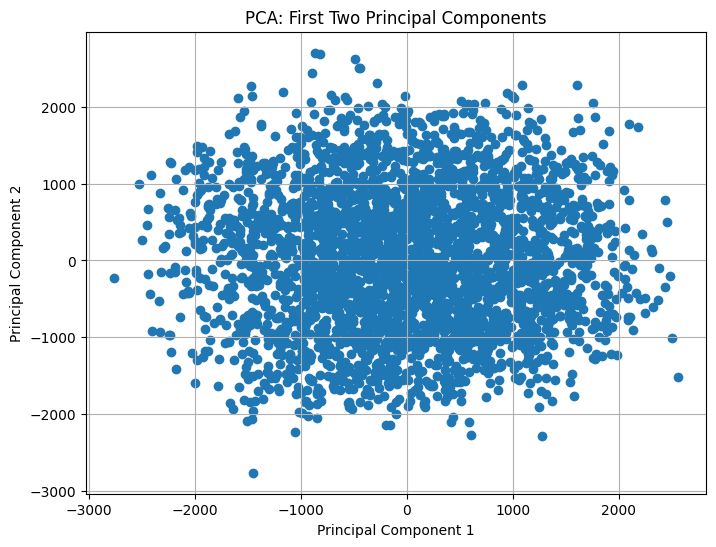

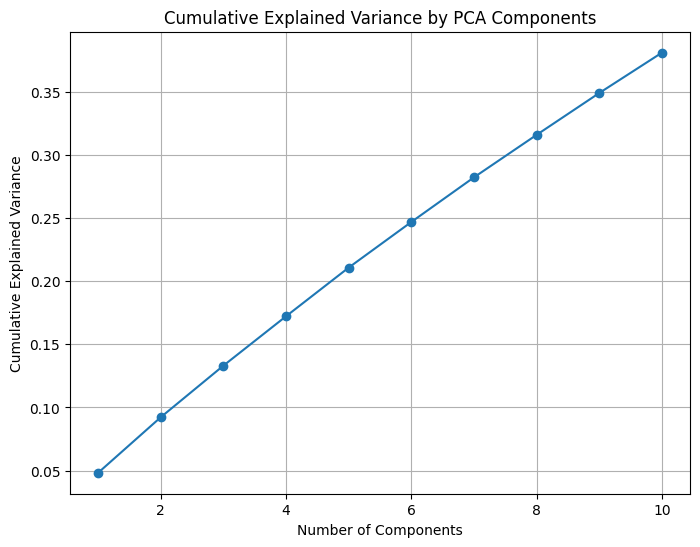

In [68]:
pca_samples(samples_no_lac_unb_df)

In [45]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

significant_diff_reactions, not_significant_diff_reactions, pval_dict, fold_change_dict = significantly_altered_reactions(
    conditions = [np.asarray(mmcs_samples_unb.T), samples_no_lac],
    cobra_model = cobra.io.read_sbml_model(agora_models_path / bh_agora_filename)
)

In [ ]:
significant_diff_reactions

['NDPK8']

In [47]:
bh_model.reactions.NDPK8

Reaction identifier,NDPK8
Name,Nucleoside-Diphosphate Kinase (ATP:dADP)
Memory address,0x72ada3dda200
Stoichiometry,atp[c] + dadp[c] <=> adp[c] + datp[c] ATP + dADP <=> ADP + dATP
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [54]:
pd.DataFrame.from_dict(fold_change_dict, orient="index", columns=["fold"])

,fold
23DHMPO,0.053523
26DAPLLAT,0.009104
2AHBUTI,0.053523
2MBCOATA,0.000000
3HAD100,0.000000
...,...
r1667,0.009683
r2137,0.009337
rtranscription,0.009337
sink_dmbzid,0.000000


In [61]:
mmcs_samples_unb["EX_lac_D(e)"].mean()

26.10130825350996

In [70]:
samples_no_lac_unb_df["EX_lac_D(e)"].mean()

460.4908845835166

In [75]:
bh_model_no_lac.solver = "gurobi"
s = bh_model_no_lac.summary()

Set parameter Username
Set parameter LicenseID to value 2634947
Academic license - for non-commercial use only - expires 2026-03-11


In [78]:
s.secretion_flux.loc["EX_lac_D(e)"]

flux          -506.511263
reaction      EX_lac_D(e)
metabolite       lac_D[e]
Name: EX_lac_D(e), dtype: object

In [81]:
bh_model.solver = "gurobi"
q = bh_model.summary()

In [82]:
q.secretion_flux.loc["EX_lac_D(e)"]

flux                  0.0
reaction      EX_lac_D(e)
metabolite       lac_D[e]
Name: EX_lac_D(e), dtype: object

### **Sampling vs Flux Balance Analysis (FBA)**

In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

significant_columns, positive_rows, negative_rows = different_fluxes_over_sign(mmcs_samples, rxn_id="ACKr")

In [ ]:
for rxn_id in significant_columns:
    if positive_rows[rxn_id].mean() * negative_rows[rxn_id].mean() < 1:
        print(bh_cmodel.reactions.get_by_id(rxn_id).build_reaction_string(use_metabolite_names=True))
        print(
            rxn_id, 
            f"\nmean of {rxn_id} on positive samples {positive_rows[rxn_id].mean()} \nvs\n "
            f"mean of {rxn_id} on negative samples {negative_rows[rxn_id].mean()}"
            "\n---\n"
        )

In [ ]:
bh      = (agora_models_path / bh_agora_filename).as_posix()
model   = dingo.MetabolicNetwork.from_sbml(bh)
# sampler = dingo.PolytopeSampler(model)
# sampler.set_solver("gurobi")
# bh_opt_samples = sampler.generate_steady_states(ess=3000, psrf=True)

In [ ]:
model.lb

In [ ]:
bh      = (agora_models_path / bh_agora_filename).as_posix()
model   = dingo.MetabolicNetwork.from_sbml(bh)
model.set_opt_percentage(50)
model.lb

In [ ]:
sampler = dingo.PolytopeSampler(model)
sampler.set_solver("gurobi")
bh_half_opt_samples = sampler.generate_steady_states(ess=3000, psrf=True)

In [ ]:
sign_cols   , pos_rows,    neg_rows    = different_fluxes_over_sign(bh_opt_samples, rxn_id="EX_lac_D(e)", reactions_list=bh_dmodel.reactions)
sign_cols_05, pos_rows_05, neg_rows_05 = different_fluxes_over_sign(bh_half_opt_samples, rxn_id="EX_lac_D(e)", reactions_list=bh_dmodel.reactions)

In [ ]:
for rxn_id in sign_cols_05:
    if pos_rows_05[rxn_id].mean() * neg_rows_05[rxn_id].mean() < 1:
        print(bh_cmodel.reactions.get_by_id(rxn_id).build_reaction_string(use_metabolite_names=True))
        print(
            rxn_id, 
            f"\nmean of {rxn_id} on positive samples {pos_rows_05[rxn_id].mean()} \nvs\n "
            f"mean of {rxn_id} on negative samples {neg_rows_05[rxn_id].mean()}"
            "\n---\n"
        )

In [ ]:
dump_samples(bh_opt_samples, "results/samples/bh_opt_mmcs.pkl")

In [ ]:
bh      = (agora_models_path / bh_agora_filename).as_posix()
bh_cmodel = cobra.io.read_sbml_model(bh)

In [ ]:
bh_cmodel.reactions.get_by_id("EX_lac_L(e)")

In [ ]:
bh_cmodel.reactions.get_by_id("EX_lac_L(e)").lower_bound = 0
# bh_cmodel.reactions.get_by_id("EX_lac_L(e)").upper_bound = 0

In [ ]:
bh_dmodel_no_lac = dingo.MetabolicNetwork.from_cobra_model(bh_cmodel)

In [ ]:
sampler = dingo.PolytopeSampler(bh_dmodel_no_lac)
samples_no_lac_opt = sampler.generate_steady_states(ess=2000, psrf=True)

In [ ]:
dump_samples(samples_no_lac_opt, "results/samples/bh_opt_no_lac.pkl")

In [ ]:
from tqdm import tqdm
from cobra.flux_analysis.loopless import loopless_solution

samples_no_lac_opt_ll = get_loopless_solutions_from_samples(samples_no_lac_opt, bh_cmodel)

In [ ]:

plot_hist(bh_opt_samples, "EX_lac_L(e)", type="dingo", description = "Bh, MMCS opt, rich", dingo_model=bh_dmodel)

plot_hist(samples_no_lac_opt, "EX_lac_L(e)", type="dingo", description = "Bh, MMCS opt, no lac", dingo_model=bh_dmodel)

plot_hist(samples_no_lac_opt_ll, "EX_lac_L(e)", type="dingo", description = "Bh, MMCS opt, no lac, ll", dingo_model=bh_dmodel)



In [ ]:
np.all(mmcs_samples["ACOCT"]==0)

In [ ]:
sns.kdeplot(data, bw_adjust=0.1)
sns.rugplot(data, color="black")
plt.title("Biomass marginal distribution, optimizing for biomass")
plt.show()

Biomass value is actually fixed, as supposed to. 

In [ ]:
is_noral(optgp_samples["biomass525"])

In [ ]:
is_noral(achr_samples["biomass525"])

In [ ]:
mmcs_samples_df = pd.DataFrame(mmcs_samples, index=bh_dmodel.reactions).T
is_noral(mmcs_samples_df["biomass525"])

In [ ]:
mmcs_samples_df = pd.DataFrame(bW_samples, index=bh_dmodel.reactions).T
is_noral(mmcs_samples_df["biomass525"])

In [ ]:
mmcs_samples_df = pd.DataFrame.from_records(mmcs_samples, index=bh_dmodel.reactions).T

In [ ]:
mmcs_samples_df[(mmcs_samples_df["ACKr"]>0) & (mmcs_samples_df["biomass525"]>0)]

In [ ]:
print(
    bh_cmodel.reactions.get_by_id("ACKr").build_reaction_string(use_metabolite_names=True),
    bh_cmodel.reactions.get_by_id("ACKr").reactants
)

In [ ]:

# transpose: rows = samples, columns = reactions
ess = az.ess(np.asarray(df.T))  # array shape (n_samples, n_reactions)


In [ ]:
lags = [1, 2, 3]
autocorrs_by_lag = {lag: df.apply(lambda col: col.autocorr(lag=lag)) for lag in lags}
autocorr_df = pd.DataFrame(autocorrs_by_lag)

In [ ]:
df.T['biomass525']

In [ ]:
def is_normal(rxn_distribution):
    """
    Uses the D'Agostino and Pearson's test for normality.
    Returns True if the data is normally distributed, False otherwise.
    """
    from scipy.stats import normaltest
    stat, p_value = normaltest(rxn_distribution)
    print("p =", p_value)
    if p_value > 0.05:
        print("Data appears normally distributed.")
    else:
        print("Data does NOT appear normally distributed.")
    return p_value > 0.05

In [ ]:

def plot_hist(samples, rxn_id, type = "dingo", dingo_model=None, description=None):
    """    Plot histogram of a specific reaction's fluxes from the samples DataFrame.
    Args:
        samples_df (pd.DataFrame): DataFrame containing the sampled fluxes.
        rxn_id (str): Reaction ID to plot the histogram for.
    """

    if type == "dingo":
        samples_df = pd.DataFrame(samples, index = dingo_model.reactions)
        data       = samples_df.loc[rxn_id]

    elif type == "cobra":
        data = samples[rxn_id]

    else:
        raise ValueError("Type must be either 'dingo' or 'cobra'.")

    sns.histplot(data, bins=20, kde=False)
    plt.xlabel(f"{rxn_id} flux (mmol/gDW/h)")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {rxn_id} fluxes {description if description else ''}")

    plt.show()

    range = data.max() - data.min()
    avg   = data.mean()
    std   = data.std()

    print(f"Raction {rxn_id} has a mean of: {avg}, a std of: {std},")
    print(f"and a range of: {range}.")
    if range < 0.01 and abs(avg) > 0.01:
        print("The reaction is fixed.")
    if range < 0.01 and abs(avg) < 0.01:
        print("The reaction is zero.")

Lactate comes into the cell from the in silico environment, it passes through the periplasm and then it converts to pyruvate! 

### **Sampling the Metabolic Environment**

In [ ]:
from scripts.envBallScripts import *

model     = cobra.io.read_sbml_model(agora_models_path / 'Bacteroides_thetaiotaomicron_VPI_5482.xml')
exchanges = get_exchange_metabolites(model)

envBall = gen_environment_ball(
    exchanges,
    anaerobic=True,
    fixed_reactions={'EX_h2o(e)': 100},
    size=1000,
    total_flux=100,
    seed=666
)

solutions = apply_env_ball(model, envBall)

results_folder = root_dir / 'results' / 'env_ball'
os.makedirs(results_folder, exist_ok=True)

outputPath = results_folder / 'env_ball_reactions_cluster_bt.png'
plot_flux_heatmap(solutions, outputPath)

### **Panreactome (pangenome)**

In [ ]:
from scripts.build_pan_reactomes import make_panReactome, add_exchange, generate_binary_presence_matrix


model_folder = root_dir / 'files' / 'models' / 'AGORA' / 'pan_genome'

models = os.listdir(model_folder)

model = cobra.io.read_sbml_model(
    os.path.join(model_folder, 'Bacteroides_thetaiotaomicron_VPI_5482.xml')
)

for reaction in model.reactions:
    if reaction.objective_coefficient == 1.0:
        objective = reaction.copy()

preact = make_panReactome(model_folder, 'Bacteroides_panreactome')

# Path where we save the image and reaction presence absence table
results_folder = root_dir / 'results' / 'pan_reactome'
os.makedirs(results_folder, exist_ok=True)

# Build a presence/absence of reactions across the Bacteroides genus
generate_binary_presence_matrix(
    model_folder,
    preact,
    results_folder
)

add_exchange(preact)
preact.add_reactions([objective])
preact.reactions.get_by_id(objective.id).objective_coefficient = 1.0

solution  = preact.optimize()
print(f"Objective Value: {solution.objective_value: .2f}")

# cobra.io.write_sbml_model(preact, os.path.join(results_folder, 'bacteroides_pan_reactome.xml'))



### **panEFMs**

In [ ]:
"""
Created on Thu Jul 31 18:43:03 2025

@author: drgarza
"""

from scripts.envBallScripts import get_exchange_metabolites, gen_environment_ball
from scripts.get_panEFMs import  get_panEFM_dist, plot_reaction_freq_heatmap

# Import panreactome model 
model_path = root_dir / 'results' / 'pan_reactome' / 'bacteroides_pan_reactome.xml'
model      = cobra.io.read_sbml_model(model_path)

# Keep track of exchange reactions of the panreactome model
exchanges = get_exchange_metabolites(model)

# Build ball with 5 random media using Dirichlet distribution, makins sure it stays anaerobic
envBall = gen_environment_ball(
    exchanges,
    anaerobic       = True,
    fixed_reactions = {'EX_h2o(e)': 100},
    size            = 5,
    total_flux      = 100,
    seed            = 666
)

reactions = [i.id for i in model.reactions if i.objective_coefficient == 0]

pan_efms = {}

for i in envBall:

    print(f"Environment Simulation: {i}")
    pan_efms[i] = get_panEFM_dist(model_path, reactions, envBall[i], max_it=10)
    

# Build dataframe with distances 
frequency_df = pd.DataFrame(
    {env: np.mean(pan_efms[env], axis=0) for env in pan_efms}, 
    index=reactions
).T


results_folder = root_dir / 'results' / 'pan_efms'
os.makedirs(results_folder, exist_ok=True)

output_path = results_folder / 'pan_efms_dist.png'
plot_reaction_freq_heatmap(frequency_df, output_path=output_path, figsize=(12, 8), cmap="coolwarm")


### **Sampling the environment in a community context**

In [ ]:
from scripts.mambo import *

acetogen          = cobra.io.read_sbml_model(agora_models_path / 'Blautia_hydrogenotrophica_DSM_10507.xml')
sugar_fermenter   = cobra.io.read_sbml_model(agora_models_path / 'Bacteroides_thetaiotaomicron_VPI_5482.xml')
butyrate_producer = cobra.io.read_sbml_model(agora_models_path / 'Roseburia_intestinalis_L1_82.xml')

# Make a list of all the exchange reactions across the three models
exchanges = get_exchange_metabolites(acetogen)
exchanges = exchanges.union(get_exchange_metabolites(sugar_fermenter))
exchanges = exchanges.union(get_exchange_metabolites(butyrate_producer))

# Build a medium where each exchange reaction is present with a boundary of 1
media = {i: 1 for  i in exchanges}

# Apply this medium and solve an FBA
apply_environment(acetogen, media)
apply_environment(sugar_fermenter, media)
apply_environment(butyrate_producer, media)

Below we have a short function to wrap the run MAMBO test parts:

In [ ]:
def run_mambo(modelList, composition, media):

    medias    = [np.array(list(media.values()))]
    solutions = [current_solution(modelList, media)]

    for i in tqdm(range(1000)):  # Should be much larger

        solution, media = MCMC(media, modelList, composition, delta = 10)

        if i > 10:  # Should be much larger

            medias.append(np.array(list(media.values())))
            solutions.append(solution)

    medias  = np.array(medias)
    mediasM = medias.copy()
    medias  = medias.T

    maxMedias = np.max(mediasM, axis=1)
    mediasM   = np.array([mediasM[i]/maxMedias[i] for i in range(len(maxMedias))]).T

    mSols        = solutions.copy()
    solutions    = np.array(solutions).T
    maxSolutions = np.max(mSols, axis=1)
    mSols        = np.array([mSols[i]/maxSolutions[i] for i in range(len(maxSolutions))]).T

    # Pearson correlation between each solution returned and the composition vector
    cor = np.array([sts.pearsonr(i, composition)[0] for i in solutions.T])
    print(f"Correlation: {cor}")

    avM = np.median(medias.T[cor>max(cor)*0.99], axis=0)
    avM = (avM/max(avM))*10

    m = {list(media.keys())[i]: avM[i] for i in range(len(avM))}

    print(f"composition was {composition} \t MAMBO solution was: {current_solution(modelList, m)}")

    sorter     = np.argsort(cor)
    result     = medias.T[sorter].T
    cor_sorted = cor[sorter]

    return result, cor_sorted

In this approach, the order that the taxa and their abundances appear are crucial. 
You need to keep in the same order the species you have in your `modelList` with their relative abundance in the `composition`

In [ ]:
# Order is critical, and in line with the `composition` list below
modelList = [acetogen, sugar_fermenter, butyrate_producer]

In [ ]:
# Composition vector: butyrate producer wins, since 10 (highest value) is on the last position of the list
composition = np.array([1, 0.1, 10])

# Run MAMBO for the butyrate producer winning case
result, cor_sorted = run_mambo(modelList=modelList, composition=composition, media=media)

# Build a folder for our findings if not already there
results_folder = root_dir / 'results' / 'mambo'
os.makedirs(results_folder, exist_ok=True)

# Save plot
output_path = results_folder / 'mambo_butyrateProducerWins.png'
plot_mambo_results(result, cor_sorted, output_path=output_path)

We can do the same for the case where the acetogen wins 

In [ ]:
# Set acetogen (first in the modelList) with the highest abundance (winning)
composition = np.array([10, 1, 0.1])

# Run MAMBO with acetogen-winning composition vector
result, cor_sorted = run_mambo(modelList, composition, media)

output_path = results_folder / 'mambo_acetogenWins.png'
plot_mambo_results(result, cor_sorted, output_path=output_path)

and similarly for the sugar fermentor

In [ ]:
# Set sugar fermentor (second in the modelList) with the highest abundance (winning)
composition = np.array([1, 10, 0.1])

# Run MAMBO for the sugar fermentor case
result, cor_sorted = run_mambo(modelList, composition, media)

output_path = results_folder / 'mambo_sugarFermenterWins.png'
plot_mambo_results(result, cor_sorted, output_path=output_path)

### **depr**

We will go through the solution of the $Bh$ model, using its original medium, to have some first insight of what the model is suggesting 

We can solve the model using flux balance analysis, which maximizes the objective function (usually biomass). This means obtaining the maximum flux value that is allowed to run through our objective function (referred to as the "objective value"). This also gives a solution for the optimal flux of each reaction.

In [ ]:
bh_sol, bh_up, bh_sec, bh_cs = fba_insight(bh_model)

In [ ]:
bh_cs.keys()

When we removed the compounds that are not in the cytosol from the medium, we already observe a decrease biomass and 
also, that fucose is now among the uptake reactions with a flux.


[here is why](https://pubmed.ncbi.nlm.nih.gov/6421801/)



We will go through the solution of the $Bh$ model, using its original medium, to have some first insight of what the model is suggesting 

We can solve the model using flux balance analysis, which maximizes the objective function (usually biomass). This means obtaining the maximum flux value that is allowed to run through our objective function (referred to as the "objective value"). This also gives a solution for the optimal flux of each reaction.

In [ ]:
bh_sol, bh_up, bh_sec, bh_cs = fba_insight(bh_model)


# When we removed the compounds that are not in the cytosol from the medium, we already observe a decrease biomass and 
# also, that fucose is now among the uptake reactions with a flux.


# [here is why](https://pubmed.ncbi.nlm.nih.gov/6421801/)


In [ ]:
medium_compounds = []
not_in_cytosol   = []
for ex, bound in bt_cobra.medium.items(): 
    ex1 = ex.strip("(e)")
    ex1 = ex1.strip("EX_")
    try: 
        m = bt_cobra.metabolites.get_by_id(ex1 + "[c]")
        medium_compounds.append((m.name, m.id))
    except:
        not_in_cytosol.append(ex)
        pass


print(
    "medium_compounds: ", len(medium_compounds), 
    "not_in_cytosol: ", len(not_in_cytosol),
    "overall: ", len(bt_cobra.medium)
)

In [ ]:
bt_cobra.metabolites.get_by_id("fru[c]")
bt_cobra.metabolites.get_by_id("lac_D[c]")

It also secretes: acetate, alanine, h2, nh4, serine, succinate.

In [ ]:
trunc_medium = bt_cobra.medium.copy()
for i in not_in_cytosol:
    del trunc_medium[i]
len(trunc_medium)

In [ ]:
bt_cobra.medium  = trunc_medium
bt_trunc_summary = bt_cobra.summary()
sol_trunc        = bt_cobra.optimize()

In [ ]:
bt_trunc_summary.uptake_flux.sort_values("flux")